In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from WGAN_GP import Critic, Generator, init_model
from utils import grad_penalty
import torchvision.transforms as tr

In [2]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

In [24]:
IMG_SIZE = 64
EPOCHS = 50
IMG_CHANNELS = 3
BATCH_SIZE = 64
Z_DIM = 3
LEARNING_RATE = 1e-4
FEATURE_GENERATOR = FEATURE_DISCRIMINATOR = 64
CRITIC_ITER = 5
LAMBDA_GP = 10

In [25]:
transform = tr.Compose([
    tr.Resize((IMG_SIZE, IMG_SIZE)),
    tr.ToTensor(),
    tr.Normalize([0.5 for _ in range(IMG_CHANNELS)], [0.5 for _ in range(IMG_CHANNELS)]),
])

In [26]:
data = ImageFolder('./datasets/Celeba/', transform=transform)
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

In [27]:
gen = Generator(Z_DIM, IMG_CHANNELS, FEATURE_GENERATOR).to(device)
critic = Critic(IMG_CHANNELS, FEATURE_DISCRIMINATOR).to(device)

init_model(gen)
init_model(critic)

optimizer_gen = torch.optim.Adam(gen.parameters(), lr = LEARNING_RATE, betas=(0.0, 0.9))
optimizer_disc = torch.optim.Adam(critic.parameters(), lr = LEARNING_RATE, betas=(0.0, 0.9))

In [28]:
fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)
writer_fake = SummaryWriter('./runs/WGAN_GP/fake')
writer_real = SummaryWriter('./runs/WGAN_GP/real')

In [29]:
gen.train()
critic.train()

Critic(
  (dis): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(

In [30]:
step = 0

In [31]:
for epoch in tqdm(range(EPOCHS)):
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device)

        # Train Critic
        for _ in range(CRITIC_ITER):
            noise = torch.randn((real.size(0), Z_DIM, 1, 1)).to(device)
            fake = gen(noise)
            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            gp = grad_penalty(critic, real, fake, device=device)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            )
            optimizer_disc.zero_grad()
            loss_critic.backward(retain_graph=True)
            optimizer_disc.step()

        # Train Generator
        out = critic(fake).reshape(-1)
        loss_gen = -torch.mean(out)
        optimizer_gen.zero_grad()
        loss_gen.backward()
        optimizer_gen.step()

        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{EPOCHS}] Batch [{batch_idx}/{len(dataloader)}] \
                    Loss D: {loss_critic:.4f}, Loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise)
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)
            step += 1

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [0/50] Batch [0/50]                     Loss D: 410.2242, Loss G: 0.3602
Epoch [1/50] Batch [0/50]                     Loss D: -114.8816, Loss G: 88.8085
Epoch [2/50] Batch [0/50]                     Loss D: -117.7335, Loss G: 119.1216
Epoch [3/50] Batch [0/50]                     Loss D: -101.2915, Loss G: 130.1594
Epoch [4/50] Batch [0/50]                     Loss D: -84.4763, Loss G: 122.5198
Epoch [5/50] Batch [0/50]                     Loss D: -61.5903, Loss G: 122.0166
Epoch [6/50] Batch [0/50]                     Loss D: -63.8394, Loss G: 110.2882
Epoch [7/50] Batch [0/50]                     Loss D: -43.4554, Loss G: 105.2220
Epoch [8/50] Batch [0/50]                     Loss D: -35.4885, Loss G: 98.0000
Epoch [9/50] Batch [0/50]                     Loss D: -29.7131, Loss G: 96.7639
Epoch [10/50] Batch [0/50]                     Loss D: -31.1407, Loss G: 84.7900
Epoch [11/50] Batch [0/50]                     Loss D: -23.9667, Loss G: 89.5470
Epoch [12/50] Batch [0/50]    

KeyboardInterrupt: 

#### Now let's take a look on pictures

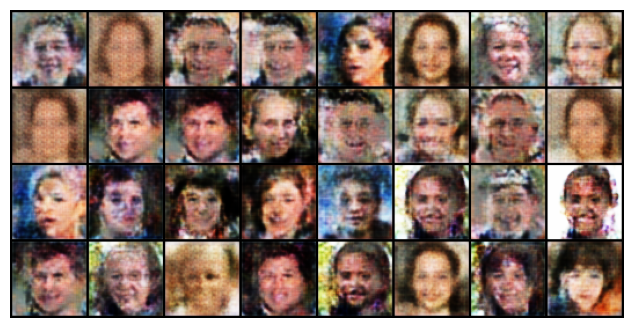

In [32]:
fake_img = gen(fixed_noise).detach().cpu()

fake_img_grid = torchvision.utils.make_grid(fake_img, normalize=True)

plt.figure(figsize=(14, 4))
plt.imshow(fake_img_grid.permute(1, 2, 0))
plt.axis("off")
plt.show()